# 🤒 Epidemic Mitigation Simulation

Our group project for the CS-456: Artificial Neural Networks/Reinforcement Learning course.

Team Member 1

> - 😀 Name: **Yiyang Feng**
> - ✉️ Email: **yiyang.feng@epfl.ch**
> - 🪪 SCIPER: **352042**

Team Member 2

> - 😀 Name: **Jiayi Sun**
> - ✉️ Email: **jiayi.sun@epfl.ch**
> - 🪪 SCIPER: **366961**

In [1]:
# Matplotlib imports
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import ScalarFormatter

# Openai gym imports
from gym import spaces

# Environment imports
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

# Pytorch and numpy imports
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

import numpy as np

# Save weights
import copy

# Named tuple for transitions
from collections import namedtuple, deque

# Random seed
import random

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# Constants
TRAIN_SEED = 352042
EVAL_SEED = 366961
SCALE = 100
DEVICE = torch.device("cpu")
ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4

TOGGLE_NULL = 0
DO_NOTHING = 1
TOGGLE_CONFINE = 2
TOGGLE_ISOLATE = 3
TOGGLE_HOSPITAL = 4
TOGGLE_VACCINATE = 5

# DQN parameters
BATCH_SIZE = 2048
GAMMA = 0.9
EPSILON = 0.7
EPSILON_LOWER_BOUND = 0.2
LR = 5e-3
LR_TOGGLE = 1e-5
TARGET_UPDATE_FREQUENCY = 5
BUFFER_SIZE = 20000
NUM_EPISODES = 500

In [4]:
# Load the switzerland map
dyn = ModelDynamics('config/switzerland.yaml')

## Question 1: Study the behavior of the model when epidemics are unmitigated

Run the epidemic simulation for one episode (30 weeks), without epidemic mitigation (meaning no action is taken, i.e. all values in the action dictionary are set to False).

In [5]:
# Load the environment
env = Env(dyn)

In [6]:
# Run the epidemic simulation for one episode (30 weeks) without any mitigation measures

weeks = 30
log = []

# Set the seed
obs, info = env.reset(TRAIN_SEED)

for _ in range(weeks):
    # Set all actions to False (no mitigation)
    action = {
        'confinement': False,
        'isolation': False,
        'vaccinate': False,
        'hospital': False,
    }
    
    # Perform one step in the environment
    obs, reward, done, info = env.step(action)

    # Collect data
    log.append(info)

In [7]:
# Parse the logs
total = {p: np.array([getattr(l.total, p) for l in log]) for p in dyn.parameters}
cities = {c: {p: np.array([getattr(l.city[c], p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a: np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

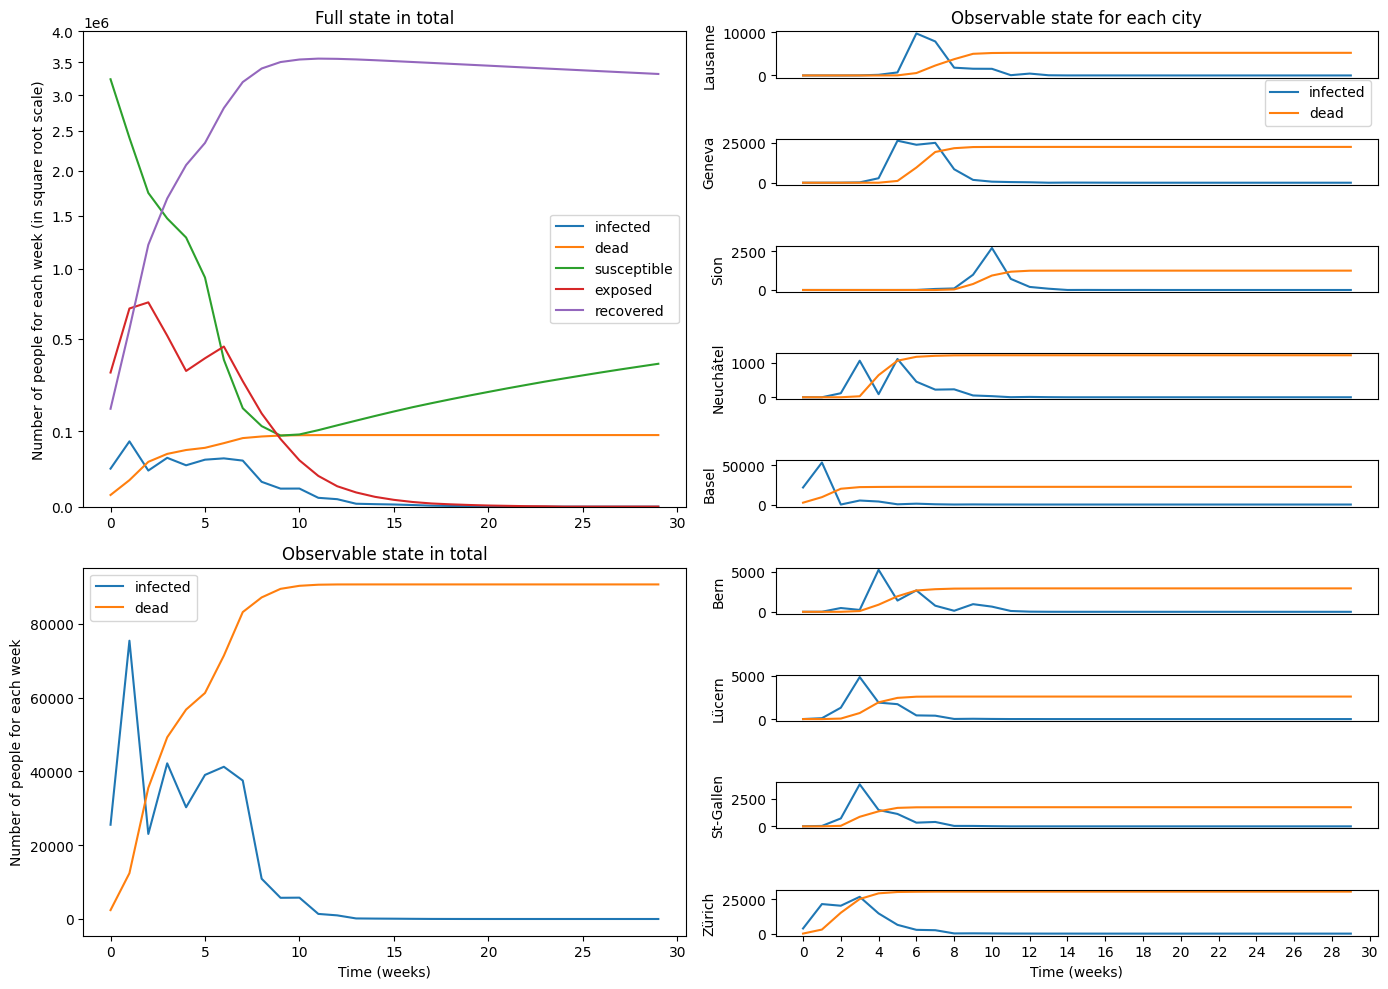

In [8]:
# Set the figure and the axes
fig = plt.figure(figsize=(14, 10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=5)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(5, 0), rowspan=4)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1, 9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

# 1.1 A plot of variables s[w] total, e[w] total, i[w] total, r[w] total, d[w] total over time
[ax_leftstate.plot(y) for key, y in total.items() if key != "initial_population"]
ax_leftstate.legend([key for key in total.keys() if key != "initial_population"])
ax_leftstate.set_title('Full state in total')
ax_leftstate.set_ylabel('Number of people for each week (in square root scale)')
ax_leftstate.set_yscale('function', functions=(np.sqrt, np.square))
ax_leftstate.yaxis.set_major_formatter(ScalarFormatter())
ax_leftstate.set_yticks([0, 0.1e6, 0.5e6, 1e6, 1.5e6, 2e6, 2.5e6, 3e6, 3.5e6, 4e6])

# 1.2 A plot of variables i[w] total, d[w] total over time
[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state in total')
ax_leftobs.set_ylabel('Number of people for each week')
ax_leftobs.set_xlabel('Time (weeks)')

# 1.3 A set of plots of variables i[w] city, d[w] city over time (one subplot per-city)
infected_line = ax_right["Zürich"].plot(cities["Zürich"]['infected'], label="infected")[0]
dead_line = ax_right["Zürich"].plot(cities["Zürich"]['dead'], label="dead")[0]

for c, ax in ax_right.items():
    if c != "Zürich":
        ax.plot(cities[c]['infected'])
        ax.plot(cities[c]['dead'])

[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Lausanne'].set_title('Observable state for each city')
ax_right['Zürich'].set_xlabel('Time (weeks)')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

# Add a single overall legend for subplots in ax_right
legend = ax_right["Lausanne"].legend([infected_line, dead_line], ["infected", "dead"], loc="upper right", bbox_to_anchor=(1, 0.1))

fig.tight_layout()
plt.show()

## Question 2: Implement Pr. Russo’s Policy

### 2.a Implement Pr. Russo’s Policy as a python class and produce four plots

In [9]:
class RussoPolicyAgent(Agent):
    def __init__(self):
        self.confine_until = None
        self.current_week = 0

    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    def reset(self,):
        # This should be called when the environment is reset
        self.confine_until = None
        self.current_week = 0

    def act(self, obs):
        infected_total = obs.total.infected[-1]

        # Check if we are still in confinement period
        if self.confine_until is not None and self.current_week < self.confine_until:
            self.current_week += 1
            return {'confinement': True, 'isolation': False, 'vaccinate': False, 'hospital': False}
        
        if infected_total > 20000:
            self.confine_until = self.current_week + 4
            self.current_week += 1
            return {'confinement': True, 'isolation': False, 'vaccinate': False, 'hospital': False}
        
        self.confine_until = None
        self.current_week += 1
        return {'confinement': False, 'isolation': False, 'vaccinate': False, 'hospital': False}

In [10]:
agent = RussoPolicyAgent()

In [11]:
# Run the epidemic simulation for one episode with Pr. Russo's policy
weeks = 30
log = []

# Set the environment and the agent
obs, info = env.reset(TRAIN_SEED)
agent.reset()

for week in range(env.ep_len):
    agent.current_week = week
    action = agent.act(obs)
    obs, reward, done, info = env.step(action)
    log.append(info)

    if done:
        break

In [12]:
# Parse the logs
total = {p: np.array([getattr(l.total, p) for l in log]) for p in dyn.parameters}
cities = {c: {p: np.array([getattr(l.city[c], p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a: np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

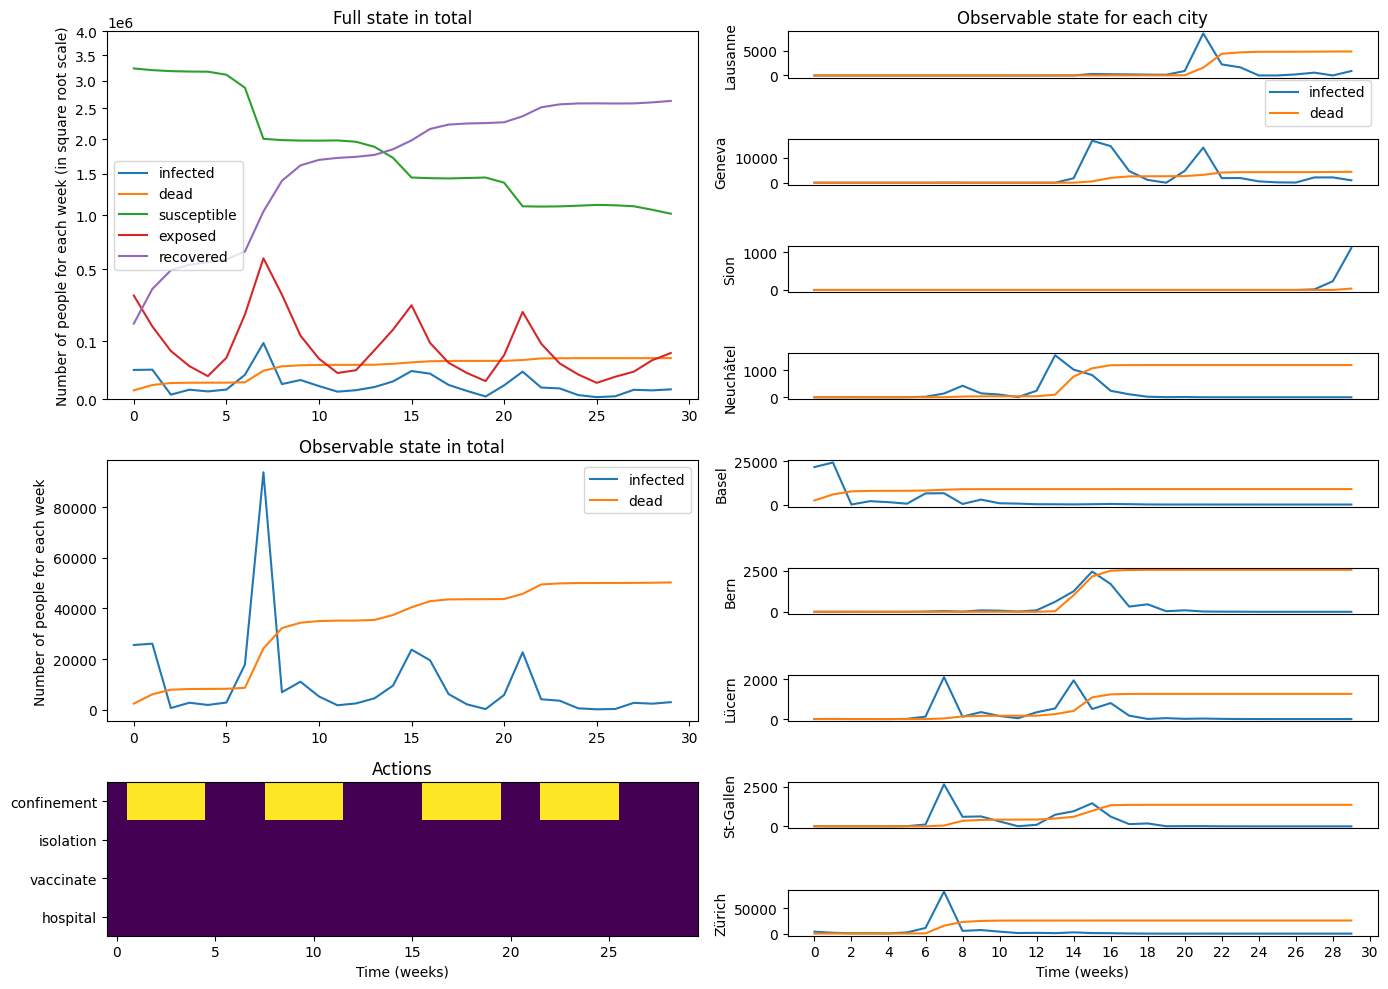

In [13]:
# Set the figure and the axes
fig = plt.figure(figsize=(14, 10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1, 9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

# 2.a.1 A plot of variables s[w] total, e[w] total, i[w] total, r[w] total, d[w] total over time
[ax_leftstate.plot(y) for key, y in total.items() if key != "initial_population"]
ax_leftstate.legend([key for key in total.keys() if key != "initial_population"])
ax_leftstate.set_title('Full state in total')
ax_leftstate.set_ylabel('Number of people for each week (in square root scale)')
ax_leftstate.set_yscale('function', functions=(np.sqrt, np.square))
ax_leftstate.yaxis.set_major_formatter(ScalarFormatter())
ax_leftstate.set_yticks([0, 0.1e6, 0.5e6, 1e6, 1.5e6, 2e6, 2.5e6, 3e6, 3.5e6, 4e6])

# 2.a.2 A plot of variables i[w] total, d[w] total over time
[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state in total')
ax_leftobs.set_ylabel('Number of people for each week')

# 2.a.4 A plot of the action taken by the policy over time
ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('Time (weeks)')

# 2.a.3 A set of plots of variables i[w] city, d[w] city over time (one subplot per-city)
infected_line = ax_right["Zürich"].plot(cities["Zürich"]['infected'], label="infected")[0]
dead_line = ax_right["Zürich"].plot(cities["Zürich"]['dead'], label="dead")[0]

for c, ax in ax_right.items():
    if c != "Zürich":
        ax.plot(cities[c]['infected'])
        ax.plot(cities[c]['dead'])

[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Lausanne'].set_title('Observable state for each city')
ax_right['Zürich'].set_xlabel('Time (weeks)')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

# Add a single overall legend for subplots in ax_right
legend = ax_right["Lausanne"].legend([infected_line, dead_line], ["infected", "dead"], loc="upper right", bbox_to_anchor=(1, 0.1))

fig.tight_layout()
plt.show()

### Question 2.b Evaluate Pr. Russo’s Policy

In [14]:
# Set the number of episodes
n_episodes = 50

In [15]:
# Evaluate policy that can be reusable
def evaluate_policy(agent, env, n_episodes=50, seed=None):
    # Set a deterministic sequence of seeds
    if seed is not None:
        torch.manual_seed(seed)
        torch.use_deterministic_algorithms(True)
    seeds = torch.randint(1, int(1e5), (n_episodes,))

    N_confinement = []
    N_isolation = []
    N_vaccinate = []
    N_hospital = []
    
    R_cumulative = []
    N_deaths = []
    
    for episode in range(n_episodes):
        
        obs, info = env.reset(seeds[episode].item())
        agent.reset()
        log = []
        total_reward = 0
        
        for week in range(env.ep_len):
            action = agent.act(obs)
            obs, reward, done, info = env.step(action)
            log.append(info)
            total_reward += reward.item()

            if done:
                break

        total_confined_weeks = sum([1 for l in log if l.action['confinement']])
        total_isolation_weeks = sum([1 for l in log if l.action['isolation']])
        total_vaccinate_weeks = sum([1 for l in log if l.action['vaccinate']])
        total_hospital_weeks = sum([1 for l in log if l.action['hospital']])
        N_confinement.append(total_confined_weeks * 7)
        N_isolation.append(total_isolation_weeks * 7)
        N_vaccinate.append(total_vaccinate_weeks * 7)
        N_hospital.append(total_hospital_weeks * 7)
        R_cumulative.append(total_reward)
        N_deaths.append(log[-1].total.dead)

    return R_cumulative, N_deaths, N_confinement, N_isolation, N_vaccinate, N_hospital

In [16]:
# Run the evaluation procedure for Pr. Russo's policy
R_cumulative, N_deaths, N_confinement, _, _, _ = evaluate_policy(agent, env, n_episodes=50, seed=EVAL_SEED)

In [17]:
# Plot histograms with the average number (in red lines)
def plot_histogram_with_avg(ax, data, title):
    ymax = 50
    if title == 'Deaths':
        x_range = (1000, 200000)
    elif title == 'Cumulative Rewards': 
        x_range = (-300, 300)
    elif 'Days' in title:
        x_range = (0, 210)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0, ymax)
    ax.vlines([np.mean(data)], 0, ymax, color='red')
    ax.hist(data, bins=60, range=x_range)
    # Rotate x-axis labels
    for label in ax.get_xticklabels():
        label.set_rotation(45)

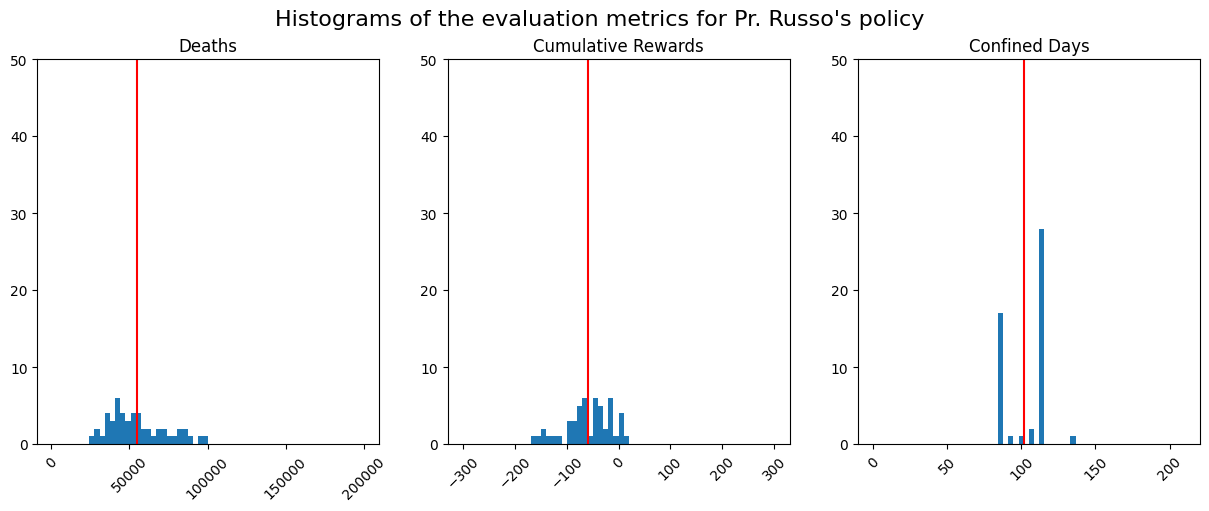

In [18]:
# Set figure size
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms for N_confinement, R_cumulative, and N_deaths
plot_histogram_with_avg(ax[0], N_deaths, 'Deaths')
plot_histogram_with_avg(ax[1], R_cumulative, 'Cumulative Rewards')
plot_histogram_with_avg(ax[2], N_confinement, 'Confined Days')
fig.subplots_adjust()
fig.suptitle('Histograms of the evaluation metrics for Pr. Russo\'s policy', fontsize=16)
plt.show()

## Question 3: Implement Pr. Russo’s Policy

In [19]:
# Set a deterministic sequence of seeds
torch.manual_seed(TRAIN_SEED)
torch.use_deterministic_algorithms(True)

class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)

In [20]:
class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size, seed=None):
        if seed is not None:
            random.seed(seed)
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [21]:
class RussoDQNAgent(Agent):
    def __init__(self, input_size, output_size, batch_size=BATCH_SIZE, gamma=GAMMA, memory_capacity=BUFFER_SIZE, device=DEVICE):
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.device = device
        self.memory_capacity = memory_capacity
        self.memory = ReplayMemory(capacity=memory_capacity)

        self.policy_net = DQN(input_size, output_size).to(device)
        self.target_net = DQN(input_size, output_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.episode_number = 0

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR, amsgrad=True)

    def reset(self, reset_memory=False):
        if reset_memory:
            self.memory = ReplayMemory(capacity=self.memory_capacity)

    def act(self, obs, epsilon=None, seed=None, decay_epsilon=False):
        if epsilon is None:
            epsilon = 0

        if decay_epsilon:
            assert epsilon is not None, 'Epsilon must be provided to decay it'
            assert epsilon > EPSILON_LOWER_BOUND, 'Epsilon must be greater than its lower bound'
            epsilon = max(epsilon*(NUM_EPISODES-self.episode_number)/NUM_EPISODES, EPSILON_LOWER_BOUND)
            
        with torch.no_grad():
            obs = obs.to(self.device).flatten()
            action_values = self.policy_net(obs)
            
        # Epsilon-greedy policy, use a seed to reproduce the same results
        if seed is not None:
            np.random.seed(seed)
        
        if np.random.rand() < epsilon:
            if seed is not None:
                np.random.seed(seed)
            action = np.random.randint(self.output_size)
        else:
            action = torch.argmax(action_values, dim=0).item()
        
        self.episode_number += 1
        return action

    def optimize_model(self, seed=None):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size, seed=seed)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                batch.next_state)), device=self.device, dtype=torch.bool)   # shape (non_final_batch_size)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])   # shape (non_final_batch_size, input_size)
        state_batch = torch.cat(batch.state)    # shape (batch_size, input_size)
        action_batch = torch.cat(batch.action)  # shape (batch_size, 1)
        reward_batch = torch.cat(batch.reward)  # shape (batch_size)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)  # shape (batch_size, 1)

        next_state_values = torch.zeros(self.batch_size, device=self.device)    # shape (batch_size)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]    # shape(batch_size)

        expected_state_action_values = (next_state_values * self.gamma) + reward_batch  # shape (batch_size)

        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        return loss.item()

    def load_model(self, savepath):
        self.policy_net.load_state_dict(torch.load(savepath))
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def save_model(self, savepath):
        torch.save(self.policy_net.state_dict(), savepath)

    def store_transition(self, state, action, next_state, reward):
        # Process the transition for storing in the replay memory
        state = state.to(self.device).flatten().view(1, -1)
        next_state = next_state.to(self.device).flatten().view(1, -1)
        action = torch.tensor([[action]], device=self.device)
        reward = torch.tensor([reward], device=self.device)
        # Create a transition tuple
        transition = (state, action, next_state, reward)
        
        # Store the transition in replay memory
        self.memory.push(*transition)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def get_weights(self):
        return copy.deepcopy(self.policy_net.state_dict())

In [22]:
# Load the action preprocessor and the observation preprocessor
def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = {
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True
        
    return action
    
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    # TODO: I'm not sure how to scale. Remark on pre-processing: note that if you "naively" scale the observations, you will end up with really small values in the observation tensor (since the number of deaths is much smaller than the total population). To avoid this, we recommend that you pass the (scaled) observations through a (·)^(1/4) function. Also the input to DQN is a 1D vector, so you need to flatten the observation tensor.
    
    infected = SCALE*np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])**(1/4)   # percentage of infected people in each city (scaled to the power of 1/4)
    dead = SCALE*np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])**(1/4)           # percentage of dead people in each city (scaled to the power of 1/4)
    return torch.tensor(np.stack((infected, dead)), dtype=torch.float32)


# Load the action space and the observation space
action_space        =   spaces.Discrete(2)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float32)

In [23]:
# Define the environment
env = Env(
    dyn,
    action_space=action_space,
    observation_space=observation_space,
    action_preprocessor=action_preprocessor,
    observation_preprocessor=observation_preprocessor,
)

In [24]:
# Define the named tuple for transitions
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

### Question 3.a Train a DQN

In [25]:
# Define the number of training episodes
n_training_episodes = NUM_EPISODES
# Define the number of evaluation episodes
n_evaluation_episodes = 20
# Training times
training_times = 3
# Define the evaluation frequency
eval_freq = 50

In [26]:
# Initialize lists to track rewards
training_rewards_3a = [[] for _ in range(training_times)]
evaluation_rewards_3a = [[] for _ in range(training_times)]
best_t_3a = None

for t in range(training_times):
    # Save the best
    best_eval_reward = -float('inf')
    best_weights = None
    print(f"Training {t+1}/{training_times}")
    # Set a deterministic sequence of seeds
    torch.manual_seed(TRAIN_SEED*(t+1))
    torch.use_deterministic_algorithms(True)
    train_seeds = torch.randint(1, int(1e5), (n_training_episodes,))
    # Initialize the agent
    agent = RussoDQNAgent(
        input_size=2*dyn.n_cities*dyn.env_step_length,
        output_size=2,
    )
    # Training loop
    for episode in range(n_training_episodes):
        # Reset the environment with seeds and get the initial observation
        obs, info = env.reset(seed=train_seeds[episode].item())
        # Initialize the cumulative reward for the episode
        cumulative_reward = 0
        # Set the sequence of seeds for epsilon-greedy policy
        torch.manual_seed(train_seeds[episode].item())
        torch.use_deterministic_algorithms(True)
        seeds_for_episode = torch.randint(1, int(1e5), (env.ep_len,))
        
        for week in range(env.ep_len):
            # Set seed for this step
            seed = seeds_for_episode[week].item()
            # Select action using epsilon-greedy policy
            action = agent.act(obs, epsilon=EPSILON, seed=seed)
            # Take a step in the environment
            next_obs, reward, done, info = env.step(action)
            # print(action, reward)

            # Store the transition in agent's replay memory
            agent.store_transition(obs, action, next_obs, reward)

            # Perform one optimization step
            loss = agent.optimize_model(seed=seed)

            # Update cumulative reward
            cumulative_reward += reward.item()

            # Move to the next observation
            obs = next_obs

            if done:
                break

        # Log the cumulative reward for this episode
        training_rewards_3a[t].append(cumulative_reward)

        # Update the target network every 5 episodes
        if (episode+1) % TARGET_UPDATE_FREQUENCY == 0:
            agent.update_target_network()
        
        # Evaluate the policy every eval_freq episodes
        if (episode + 1) % eval_freq == 0 or episode == n_episodes - 1:
        # if (episode + 1) % 1 == 0 or episode == n_episodes - 1:
            # Evaluate the current policy
            R_cumulative, N_deaths, N_confinement, _, _, _ = evaluate_policy(agent, env, n_evaluation_episodes, seed=EVAL_SEED)

            # Log the cumulative reward for this episode
            avg_eval_reward = sum(R_cumulative) / n_evaluation_episodes
            evaluation_rewards_3a[t].append(avg_eval_reward)

            # Save the weights of the best model so far
            if avg_eval_reward > best_eval_reward:
                best_eval_reward = avg_eval_reward
                best_weights = agent.get_weights()
                best_t_3a = t
                agent.save_model(savepath=f'models/agent_3a_{str(t)}.pt')

            # Print the cumulative reward for this evaluation episode
            print(f'Episode {episode+1} - Evaluation: Average reward = {avg_eval_reward:.2f}')

            # Print the cumulative reward for this training episode
            print(f'Episode {episode+1} - Training: Cumulative reward = {cumulative_reward:.2f}')

Training 1/3
Episode 50 - Evaluation: Average reward = -101.42
Episode 50 - Training: Cumulative reward = -76.70
Episode 100 - Evaluation: Average reward = 23.25
Episode 100 - Training: Cumulative reward = -71.20
Episode 150 - Evaluation: Average reward = 27.46
Episode 150 - Training: Cumulative reward = 13.77
Episode 200 - Evaluation: Average reward = 25.12
Episode 200 - Training: Cumulative reward = -152.96
Episode 250 - Evaluation: Average reward = 26.81
Episode 250 - Training: Cumulative reward = 14.93
Episode 300 - Evaluation: Average reward = 28.40
Episode 300 - Training: Cumulative reward = -194.49
Episode 350 - Evaluation: Average reward = 30.66
Episode 350 - Training: Cumulative reward = -141.97
Episode 400 - Evaluation: Average reward = 30.70
Episode 400 - Training: Cumulative reward = -48.02
Episode 450 - Evaluation: Average reward = 34.83
Episode 450 - Training: Cumulative reward = -88.79
Episode 500 - Evaluation: Average reward = 36.94
Episode 500 - Training: Cumulative re

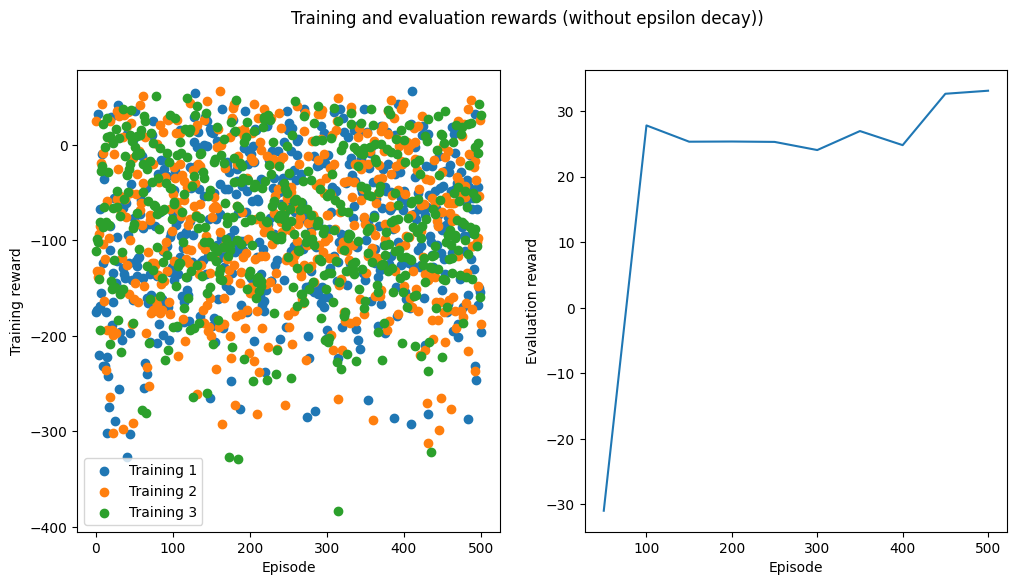

In [27]:
# Plot three training rewards in one scatter plot, and average three evaluation rewards in a line plot. Two figures up and down.
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(range(1, n_training_episodes+1), training_rewards_3a[0], label='Training 1')
ax[0].scatter(range(1, n_training_episodes+1), training_rewards_3a[1], label='Training 2')
ax[0].scatter(range(1, n_training_episodes+1), training_rewards_3a[2], label='Training 3')
ax[0].legend()
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Training reward')
ax[1].plot(range(eval_freq, n_training_episodes+1, eval_freq), [sum(x)/len(x) for x in zip(*evaluation_rewards_3a)])
ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Evaluation reward')
fig.suptitle('Training and evaluation rewards (without epsilon decay))')
fig.subplots_adjust()
plt.show()

Plot one episode with the best model from question 3.a.

In [28]:
print(best_t_3a)
agent = RussoDQNAgent(
    input_size=2*dyn.n_cities*dyn.env_step_length,
    output_size=2,
)
agent.load_model(savepath='models/agent_3a_2.pt')
# Run the epidemic simulation for one episode with DQN as question 2.a
log = []

# Set the environment and the agent
obs, info = env.reset(TRAIN_SEED)
agent.reset()

for week in range(env.ep_len):
    action = agent.act(obs)
    obs, reward, done, info = env.step(action)
    log.append(info)

    if done:
        break

2


In [29]:
# Parse the logs
total = {p: np.array([getattr(l.total, p) for l in log]) for p in dyn.parameters}
cities = {c: {p: np.array([getattr(l.city[c], p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a: np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

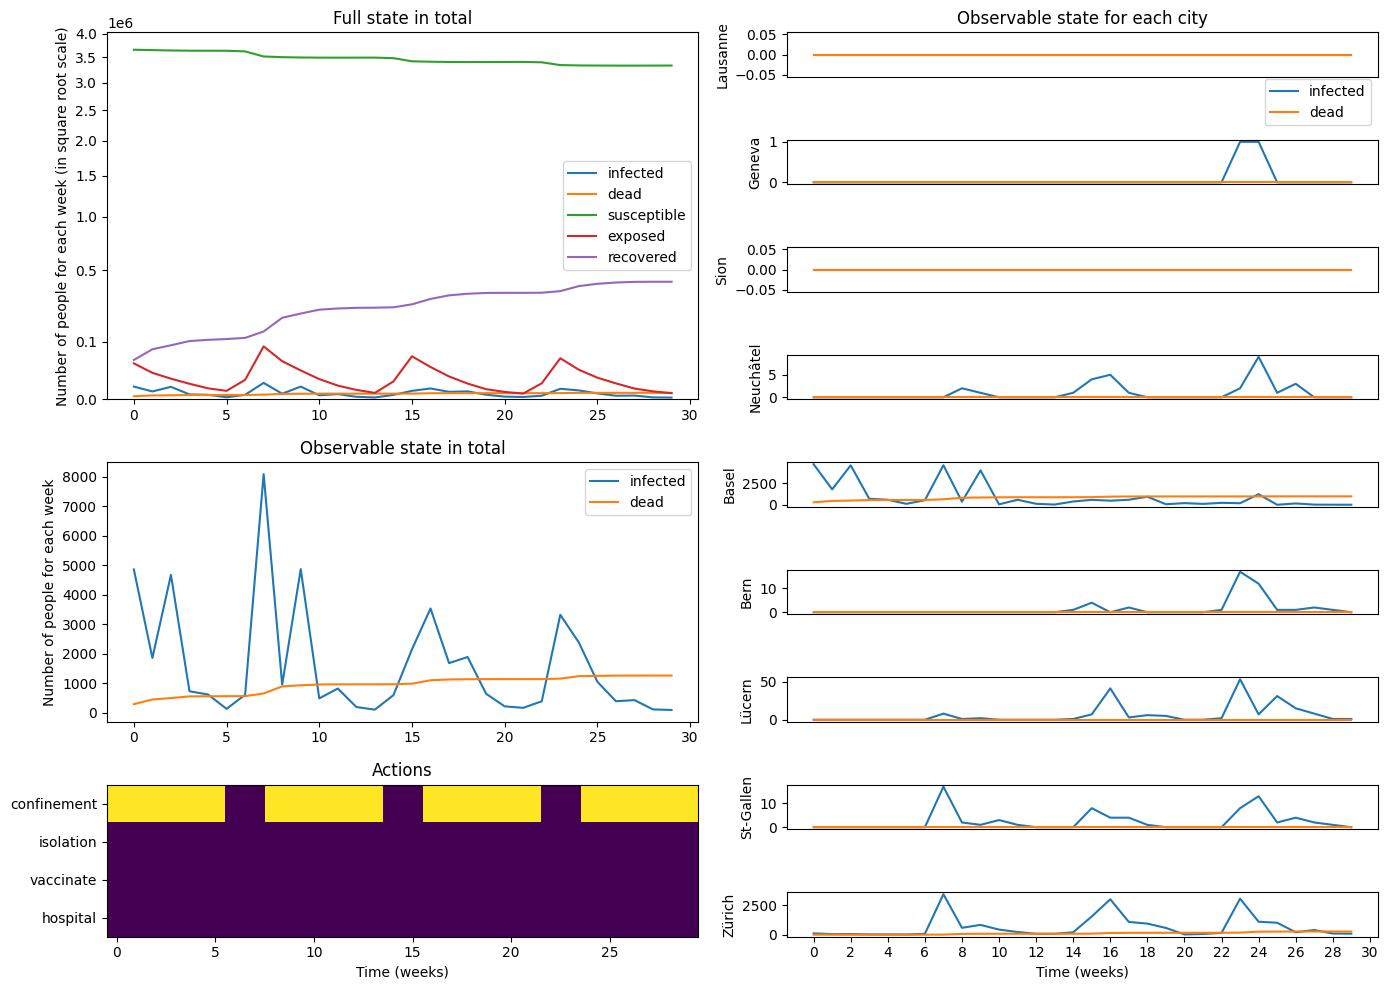

In [30]:
# Set the figure and the axes
fig = plt.figure(figsize=(14, 10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1, 9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

# 2.a.1 A plot of variables s[w] total, e[w] total, i[w] total, r[w] total, d[w] total over time
[ax_leftstate.plot(y) for key, y in total.items() if key != "initial_population"]
ax_leftstate.legend([key for key in total.keys() if key != "initial_population"])
ax_leftstate.set_title('Full state in total')
ax_leftstate.set_ylabel('Number of people for each week (in square root scale)')
ax_leftstate.set_yscale('function', functions=(np.sqrt, np.square))
ax_leftstate.yaxis.set_major_formatter(ScalarFormatter())
ax_leftstate.set_yticks([0, 0.1e6, 0.5e6, 1e6, 1.5e6, 2e6, 2.5e6, 3e6, 3.5e6, 4e6])

# 2.a.2 A plot of variables i[w] total, d[w] total over time
[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state in total')
ax_leftobs.set_ylabel('Number of people for each week')

# 2.a.4 A plot of the action taken by the policy over time
ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('Time (weeks)')

# 2.a.3 A set of plots of variables i[w] city, d[w] city over time (one subplot per-city)
infected_line = ax_right["Zürich"].plot(cities["Zürich"]['infected'], label="infected")[0]
dead_line = ax_right["Zürich"].plot(cities["Zürich"]['dead'], label="dead")[0]

for c, ax in ax_right.items():
    if c != "Zürich":
        ax.plot(cities[c]['infected'])
        ax.plot(cities[c]['dead'])

[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Lausanne'].set_title('Observable state for each city')
ax_right['Zürich'].set_xlabel('Time (weeks)')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

# Add a single overall legend for subplots in ax_right
legend = ax_right["Lausanne"].legend([infected_line, dead_line], ["infected", "dead"], loc="upper right", bbox_to_anchor=(1, 0.1))

fig.tight_layout()
plt.show()

### Question 3.b Decreasing Exploration

In [31]:
# Initialize lists to track rewards
training_rewards_3b = [[] for _ in range(training_times)]
evaluation_rewards_3b = [[] for _ in range(training_times)]
best_t_3b = None

for t in range(training_times):
    # Save the best
    best_eval_reward = -float('inf')
    best_weights = None
    print(f"Training {t+1}/{training_times}")
    # Set a deterministic sequence of seeds
    torch.manual_seed(TRAIN_SEED*(t+1))
    torch.use_deterministic_algorithms(True)
    train_seeds = torch.randint(1, int(1e5), (n_training_episodes,))
    # Initialize the agent
    agent = RussoDQNAgent(
        input_size=2*dyn.n_cities*dyn.env_step_length,
        output_size=2,
    )
    # Reset the agent's internal state
    agent.reset(reset_memory=True)
    # Training loop
    for episode in range(n_training_episodes):
        # Reset the environment with seeds and get the initial observation
        obs, info = env.reset(seed=train_seeds[episode].item())
        # Initialize the cumulative reward for the episode
        cumulative_reward = 0
        # Set the sequence of seeds for epsilon-greedy policy
        torch.manual_seed(train_seeds[episode].item())
        torch.use_deterministic_algorithms(True)
        seeds_for_episode = torch.randint(1, int(1e5), (env.ep_len,))
        
        for week in range(env.ep_len):
            # Set seed for this step
            seed = seeds_for_episode[week].item()
            # Select action using epsilon-greedy policy
            action = agent.act(obs, epsilon=EPSILON, seed=seed, decay_epsilon=True)
            # Take a step in the environment
            next_obs, reward, done, info = env.step(action)
            # print(action, reward)

            # Store the transition in agent's replay memory
            agent.store_transition(obs, action, next_obs, reward)

            # Perform one optimization step
            loss = agent.optimize_model(seed=seed)

            # Update cumulative reward
            cumulative_reward += reward.item()

            # Move to the next observation
            obs = next_obs

            if done:
                break

        # Log the cumulative reward for this episode
        training_rewards_3b[t].append(cumulative_reward)

        # Update the target network every 5 episodes
        if (episode+1) % TARGET_UPDATE_FREQUENCY == 0:
            agent.update_target_network()
        
        # Evaluate the policy every eval_freq episodes
        if (episode + 1) % eval_freq == 0 or episode == n_episodes - 1:
        # if (episode + 1) % 1 == 0 or episode == n_episodes - 1:
            # Evaluate the current policy
            R_cumulative, N_deaths, N_confinement, _, _, _ = evaluate_policy(agent, env, n_evaluation_episodes, seed=EVAL_SEED)

            # Log the cumulative reward for this episode
            avg_eval_reward = sum(R_cumulative) / n_evaluation_episodes
            evaluation_rewards_3b[t].append(avg_eval_reward)

            # Save the weights of the best model so far
            if avg_eval_reward > best_eval_reward:
                best_eval_reward = avg_eval_reward
                best_weights = agent.get_weights()
                best_t_3b = t
                agent.save_model(savepath=f'models/agent_3b_{str(t)}.pt')

            # Print the cumulative reward for this evaluation episode
            print(f'Episode {episode+1} - Evaluation: Average reward = {avg_eval_reward:.2f}')

            # Print the cumulative reward for this training episode
            print(f'Episode {episode+1} - Training: Cumulative reward = {cumulative_reward:.2f}')

Training 1/3
Episode 50 - Evaluation: Average reward = -101.42
Episode 50 - Training: Cumulative reward = -27.08
Episode 100 - Evaluation: Average reward = 18.08
Episode 100 - Training: Cumulative reward = 24.52
Episode 150 - Evaluation: Average reward = 27.11
Episode 150 - Training: Cumulative reward = 52.44
Episode 200 - Evaluation: Average reward = 25.27
Episode 200 - Training: Cumulative reward = 17.70
Episode 250 - Evaluation: Average reward = 21.36
Episode 250 - Training: Cumulative reward = 27.90
Episode 300 - Evaluation: Average reward = 28.83
Episode 300 - Training: Cumulative reward = -4.64
Episode 350 - Evaluation: Average reward = 35.38
Episode 350 - Training: Cumulative reward = -73.44
Episode 400 - Evaluation: Average reward = 32.82
Episode 400 - Training: Cumulative reward = -128.15
Episode 450 - Evaluation: Average reward = 34.35
Episode 450 - Training: Cumulative reward = 15.60
Episode 500 - Evaluation: Average reward = 37.64
Episode 500 - Training: Cumulative reward =

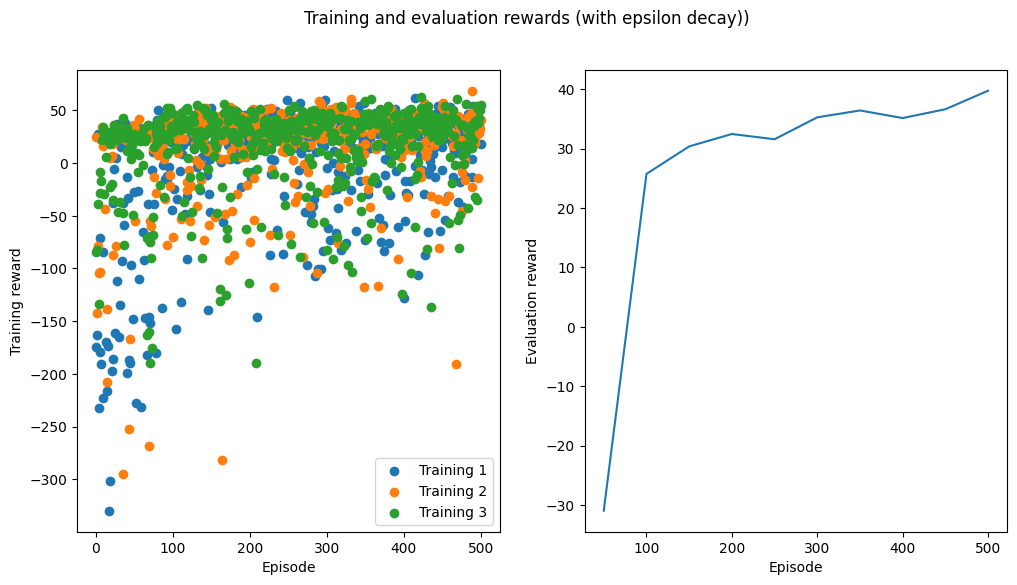

In [32]:
# Plot three training rewards in one scatter plot, and average three evaluation rewards in a line plot. Two figures up and down.
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(range(1, n_training_episodes+1), training_rewards_3b[0], label='Training 1')
ax[0].scatter(range(1, n_training_episodes+1), training_rewards_3b[1], label='Training 2')
ax[0].scatter(range(1, n_training_episodes+1), training_rewards_3b[2], label='Training 3')
ax[0].legend()
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Training reward')
ax[1].plot(range(eval_freq, n_training_episodes+1, eval_freq), [sum(x)/len(x) for x in zip(*evaluation_rewards_3b)])
ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Evaluation reward')
fig.suptitle('Training and evaluation rewards (with epsilon decay))')
fig.subplots_adjust()
plt.show()

### Question 3.c

Run the best model from 3.b

In [33]:
print(best_t_3b)
agent = RussoDQNAgent(
    input_size=2*dyn.n_cities*dyn.env_step_length,
    output_size=2,
)
agent.load_model(savepath='models/agent_3b_1.pt')
# Run the evaluation procedure for Pr. Russo's policy
R_cumulative, N_deaths, N_confinement, _, _, _ = evaluate_policy(agent, env, n_episodes=50, seed=EVAL_SEED)

2


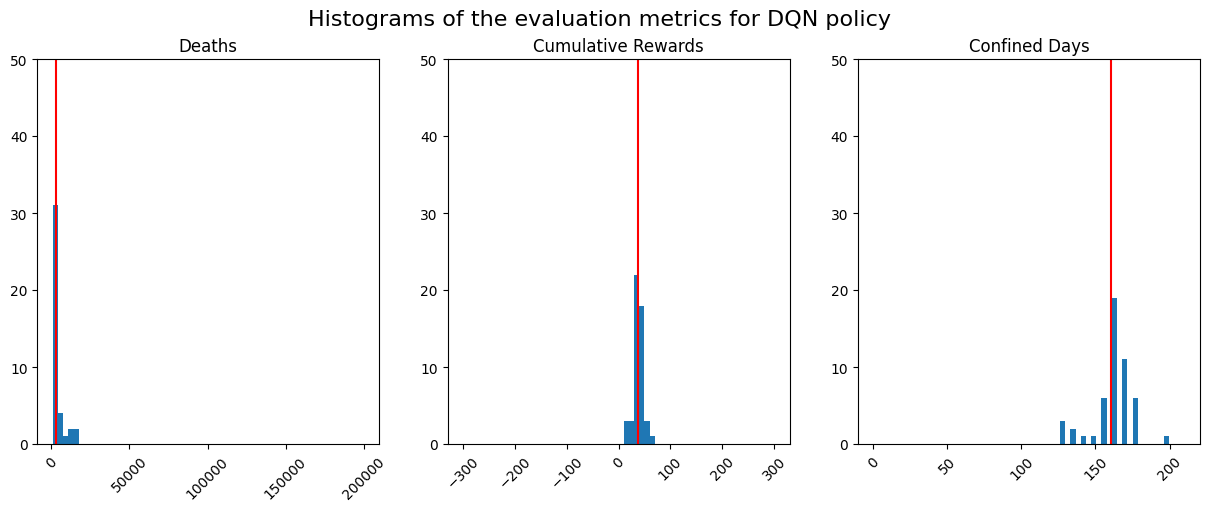

In [34]:
# Set figure size
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms for N_confinement, R_cumulative, and N_deaths
plot_histogram_with_avg(ax[0], N_deaths, 'Deaths')
plot_histogram_with_avg(ax[1], R_cumulative, 'Cumulative Rewards')
plot_histogram_with_avg(ax[2], N_confinement, 'Confined Days')
fig.subplots_adjust()
fig.suptitle('Histograms of the evaluation metrics for DQN policy', fontsize=16)
plt.show()

## Question 4 Dealing with complex action space

### Question 4.1 Toggle-action space multi-action agent

### Question 4.1.b Toggle-action-space multi-action policy training

In [35]:
class ToggleDQNAgent(Agent):
    def __init__(self, input_size, output_size, batch_size=BATCH_SIZE, gamma=GAMMA, memory_capacity=BUFFER_SIZE, device=DEVICE):
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.gamma = gamma
        self.device = device
        self.memory_capacity = memory_capacity
        self.memory = ReplayMemory(capacity=memory_capacity)

        self.policy_net = DQN(input_size, output_size).to(device)
        self.target_net = DQN(input_size, output_size).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.episode_number = 0

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=LR_TOGGLE, amsgrad=True)

    def reset(self, reset_memory=False):
        if reset_memory:
            self.memory = ReplayMemory(capacity=self.memory_capacity)

    def act(self, obs, epsilon=None, seed=None, decay_epsilon=False):
        if epsilon is None:
            epsilon = 0

        if decay_epsilon:
            assert epsilon is not None, 'Epsilon must be provided to decay it'
            assert epsilon > EPSILON_LOWER_BOUND, 'Epsilon must be greater than its lower bound'
            epsilon = max(epsilon*(NUM_EPISODES-self.episode_number)/NUM_EPISODES, EPSILON_LOWER_BOUND)
            
        with torch.no_grad():
            obs = obs.to(self.device).flatten()
            action_values = self.policy_net(obs)
            
        # Epsilon-greedy policy, use a seed to reproduce the same results
        if seed is not None:
            np.random.seed(seed)
        
        if np.random.rand() < epsilon:
            if seed is not None:
                np.random.seed(seed)
            action = np.random.randint(self.output_size)
        else:
            action = torch.argmax(action_values, dim=0).item()
        
        self.episode_number += 1
        return action

    def optimize_model(self, seed=None):
        if len(self.memory) < self.batch_size:
            return

        transitions = self.memory.sample(self.batch_size, seed=seed)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                                batch.next_state)), device=self.device, dtype=torch.bool)   # shape (non_final_batch_size)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                           if s is not None])   # shape (non_final_batch_size, input_size)
        state_batch = torch.cat(batch.state)    # shape (batch_size, input_size)
        action_batch = torch.cat(batch.action)  # shape (batch_size, 1)
        reward_batch = torch.cat(batch.reward)  # shape (batch_size)

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)  # shape (batch_size, 1)

        next_state_values = torch.zeros(self.batch_size, device=self.device)    # shape (batch_size)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0]    # shape(batch_size)

        expected_state_action_values = (next_state_values * self.gamma) + reward_batch  # shape (batch_size)

        loss = F.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))

        self.optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_value_(self.policy_net.parameters(), 100)
        self.optimizer.step()
        return loss.item()

    def load_model(self, savepath):
        self.policy_net.load_state_dict(torch.load(savepath))
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def save_model(self, savepath):
        torch.save(self.policy_net.state_dict(), savepath)

    def store_transition(self, state, action, next_state, reward):
        # Process the transition for storing in the replay memory
        state = state.to(self.device).flatten().view(1, -1)
        next_state = next_state.to(self.device).flatten().view(1, -1)
        action = torch.tensor([[action]], device=self.device)
        reward = torch.tensor([reward], device=self.device)
        # Create a transition tuple
        transition = (state, action, next_state, reward)
        
        # Store the transition in replay memory
        self.memory.push(*transition)

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def get_weights(self):
        return copy.deepcopy(self.policy_net.state_dict())

In [36]:
# Load the action preprocessor and the observation preprocessor
def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    action = {
        'confinement': dyn.get_action()['confinement'], 
        'isolation': dyn.get_action()['isolation'], 
        'hospital': dyn.get_action()['hospital'], 
        'vaccinate': dyn.get_action()['vaccinate'],
    }
    
    if a == TOGGLE_CONFINE:
        action['confinement'] = ~action['confinement']
    elif a == TOGGLE_ISOLATE:
        action['isolation'] = ~action['isolation']
    elif a == TOGGLE_VACCINATE:
        action['vaccinate'] = ~action['vaccinate']
    elif a == TOGGLE_HOSPITAL:
        action['hospital'] = ~action['hospital']
        
    return action
    
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    # TODO: I'm not sure how to scale. Remark on pre-processing: note that if you "naively" scale the observations, you will end up with really small values in the observation tensor (since the number of deaths is much smaller than the total population). To avoid this, we recommend that you pass the (scaled) observations through a (·)^(1/4) function. Also the input to DQN is a 1D vector, so you need to flatten the observation tensor.
    
    infected = SCALE*np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])**(1/4)   # percentage of infected people in each city (scaled to the power of 1/4)
    dead = SCALE*np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])**(1/4)           # percentage of dead people in each city (scaled to the power of 1/4)
    confinement = np.ones_like(dead)*int((dyn.get_action()['confinement']))
    isolation = np.ones_like(dead)*int((dyn.get_action()['isolation']))
    vaccination = np.ones_like(dead)*int((dyn.get_action()['vaccinate']))
    hospital = np.ones_like(dead)*int((dyn.get_action()['hospital']))
    return torch.tensor(np.stack((infected, dead, confinement, isolation, vaccination, hospital)), dtype=torch.float32)


# Load the action space and the observation space
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(6, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float32)

In [37]:
# Define the environment
env = Env(
    dyn,
    action_space=action_space,
    observation_space=observation_space,
    action_preprocessor=action_preprocessor,
    observation_preprocessor=observation_preprocessor,
)

In [38]:
# Define the number of training episodes
n_training_episodes = NUM_EPISODES
# Define the number of evaluation episodes
n_evaluation_episodes = 20
# Training times
training_times = 3
# Define the evaluation frequency
eval_freq = 50

In [39]:
# Define the named tuple for transitions
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

In [40]:
# Initialize lists to track rewards
training_rewards_41b = [[] for _ in range(training_times)]
evaluation_rewards_41b = [[] for _ in range(training_times)]
best_t_41b = None

for t in range(training_times):
    # Save the best
    best_eval_reward = -float('inf')
    best_weights = None
    print(f"Training {t+1}/{training_times}")
    # Set a deterministic sequence of seeds
    torch.manual_seed(TRAIN_SEED*(t+1))
    torch.use_deterministic_algorithms(True)
    train_seeds = torch.randint(1, int(1e5), (n_training_episodes,))
    # Initialize the agent
    agent = ToggleDQNAgent(
        input_size = 6 * dyn.n_cities * dyn.env_step_length,
        output_size = 5,
    )
    # Reset the agent's internal state
    agent.reset(reset_memory=True)
    # Training loop
    for episode in range(n_training_episodes):
        # Reset the environment with seeds and get the initial observation
        obs, info = env.reset(seed=train_seeds[episode].item())
        # Initialize the cumulative reward for the episode
        cumulative_reward = 0
        # Set the sequence of seeds for epsilon-greedy policy
        torch.manual_seed(train_seeds[episode].item())
        torch.use_deterministic_algorithms(True)
        seeds_for_episode = torch.randint(1, int(1e5), (env.ep_len,))
        
        for week in range(env.ep_len):
            # Set seed for this step
            seed = seeds_for_episode[week].item()
            # Select action using epsilon-greedy policy
            action = agent.act(obs, epsilon=EPSILON, seed=seed, decay_epsilon=True)
            # Take a step in the environment
            next_obs, reward, done, info = env.step(action)
            # print(action, reward)

            # Store the transition in agent's replay memory
            agent.store_transition(obs, action, next_obs, reward)

            # Perform one optimization step
            loss = agent.optimize_model(seed=seed)

            # Update cumulative reward
            cumulative_reward += reward.item()

            # Move to the next observation
            obs = next_obs

            if done:
                break

        # Log the cumulative reward for this episode
        training_rewards_41b[t].append(cumulative_reward)

        # Update the target network every 5 episodes
        if (episode+1) % TARGET_UPDATE_FREQUENCY == 0:
            agent.update_target_network()
        
        # Evaluate the policy every eval_freq episodes
        if (episode + 1) % eval_freq == 0 or episode == n_episodes - 1:
        # if (episode + 1) % 1 == 0 or episode == n_episodes - 1:
            # Evaluate the current policy
            R_cumulative, N_deaths, N_confinement, _, _, _ = evaluate_policy(agent, env, n_evaluation_episodes, seed=EVAL_SEED)

            # Log the cumulative reward for this episode
            avg_eval_reward = sum(R_cumulative) / n_evaluation_episodes
            evaluation_rewards_41b[t].append(avg_eval_reward)

            # Save the weights of the best model so far
            if avg_eval_reward > best_eval_reward:
                best_eval_reward = avg_eval_reward
                best_weights = agent.get_weights()
                best_t_41b = t
                agent.save_model(savepath=f'models/agent_41b_{str(t)}.pt')

            # Print the cumulative reward for this evaluation episode
            print(f'Episode {episode+1} - Evaluation: Average reward = {avg_eval_reward:.2f}')

            # Print the cumulative reward for this training episode
            print(f'Episode {episode+1} - Training: Cumulative reward = {cumulative_reward:.2f}')

Training 1/3
Episode 50 - Evaluation: Average reward = 9.90
Episode 50 - Training: Cumulative reward = 0.96
Episode 100 - Evaluation: Average reward = -3.25
Episode 100 - Training: Cumulative reward = -154.37
Episode 150 - Evaluation: Average reward = -31.21
Episode 150 - Training: Cumulative reward = -28.60
Episode 200 - Evaluation: Average reward = -15.94
Episode 200 - Training: Cumulative reward = -108.60
Episode 250 - Evaluation: Average reward = -28.92
Episode 250 - Training: Cumulative reward = -34.51
Episode 300 - Evaluation: Average reward = 15.70
Episode 300 - Training: Cumulative reward = 13.22
Episode 350 - Evaluation: Average reward = 14.77
Episode 350 - Training: Cumulative reward = 17.92
Episode 400 - Evaluation: Average reward = 20.34
Episode 400 - Training: Cumulative reward = -13.48
Episode 450 - Evaluation: Average reward = 23.18
Episode 450 - Training: Cumulative reward = 6.13
Episode 500 - Evaluation: Average reward = 24.81
Episode 500 - Training: Cumulative reward 

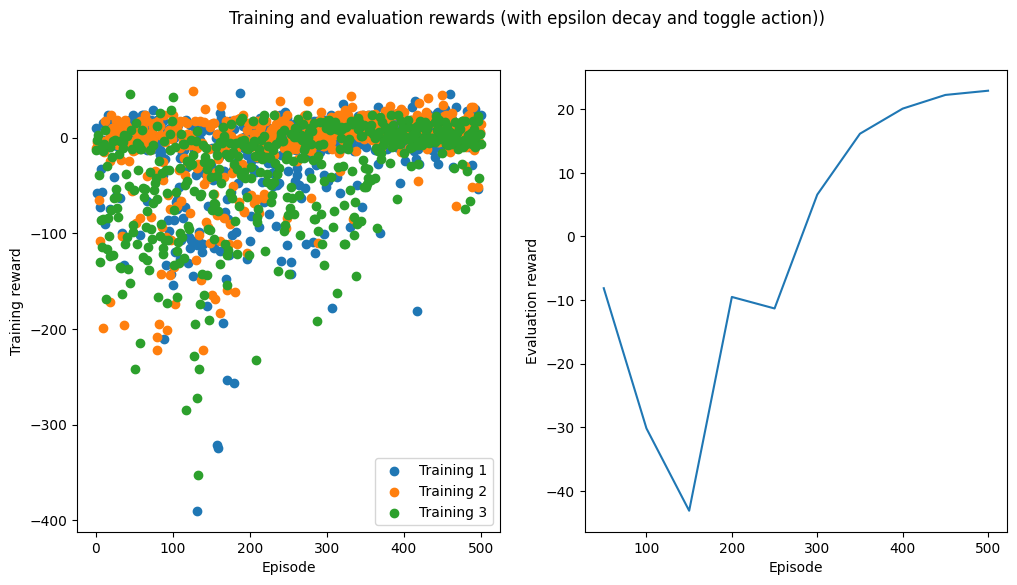

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(range(1, n_training_episodes+1), training_rewards_41b[0], label='Training 1')
ax[0].scatter(range(1, n_training_episodes+1), training_rewards_41b[1], label='Training 2')
ax[0].scatter(range(1, n_training_episodes+1), training_rewards_41b[2], label='Training 3')
ax[0].legend()
ax[0].set_xlabel('Episode')
ax[0].set_ylabel('Training reward')
ax[1].plot(range(eval_freq, n_training_episodes+1, eval_freq), [sum(x)/len(x) for x in zip(*evaluation_rewards_41b)])
ax[1].set_xlabel('Episode')
ax[1].set_ylabel('Evaluation reward')
fig.suptitle('Training and evaluation rewards (with epsilon decay and toggle action))')
fig.subplots_adjust()
plt.show()

In [44]:
print(best_t_41b)
agent = RussoDQNAgent(
    input_size=6*dyn.n_cities*dyn.env_step_length,
    output_size=5,
)
agent.load_model(savepath='models/agent_41b_2.pt')
# Run the evaluation procedure for Pr. Russo's policy
R_cumulative, N_deaths, N_confinement, _, _, _ = evaluate_policy(agent, env, n_episodes=50, seed=EVAL_SEED)

2


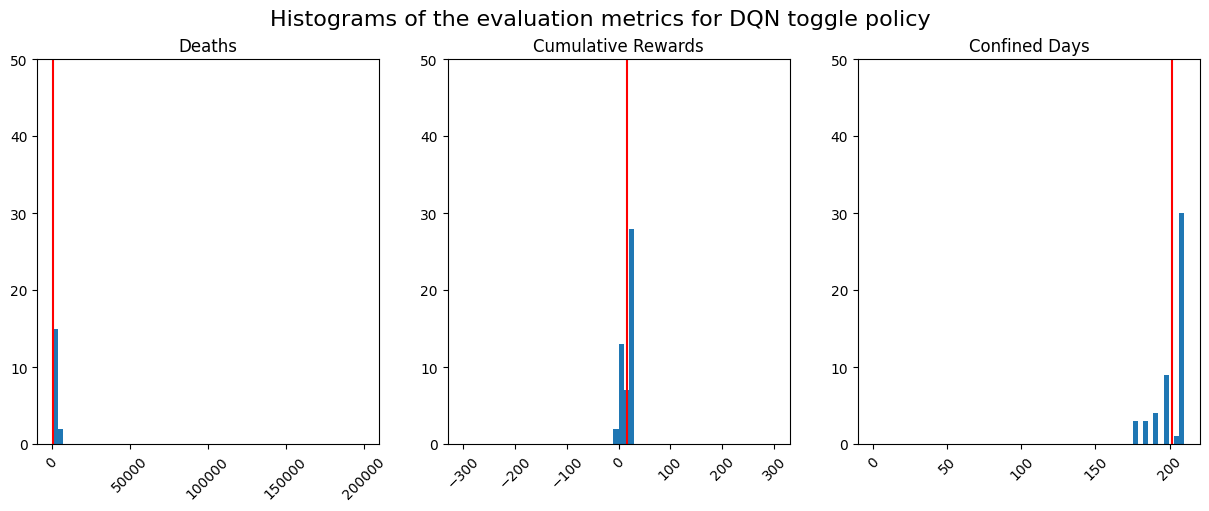

In [45]:
# Set figure size
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Plot histograms for N_confinement, R_cumulative, and N_deaths
plot_histogram_with_avg(ax[0], N_deaths, 'Deaths')
plot_histogram_with_avg(ax[1], R_cumulative, 'Cumulative Rewards')
plot_histogram_with_avg(ax[2], N_confinement, 'Confined Days')
fig.subplots_adjust()
fig.suptitle('Histograms of the evaluation metrics for DQN toggle policy', fontsize=16)
plt.show()

In [46]:
print(best_t_41b)
agent = RussoDQNAgent(
    input_size=6*dyn.n_cities*dyn.env_step_length,
    output_size=5,
)
agent.load_model(savepath='models/agent_41b_2.pt')
# Run the epidemic simulation for one episode with DQN as question 2.a
log = []

# Set the environment and the agent
obs, info = env.reset(TRAIN_SEED)
agent.reset()

for week in range(env.ep_len):
    action = agent.act(obs)
    obs, reward, done, info = env.step(action)
    log.append(info)

    if done:
        break

2


In [47]:
# Parse the logs
total = {p: np.array([getattr(l.total, p) for l in log]) for p in dyn.parameters}
cities = {c: {p: np.array([getattr(l.city[c], p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
actions = {a: np.array([l.action[a] for l in log]) for a in log[0].action.keys()}

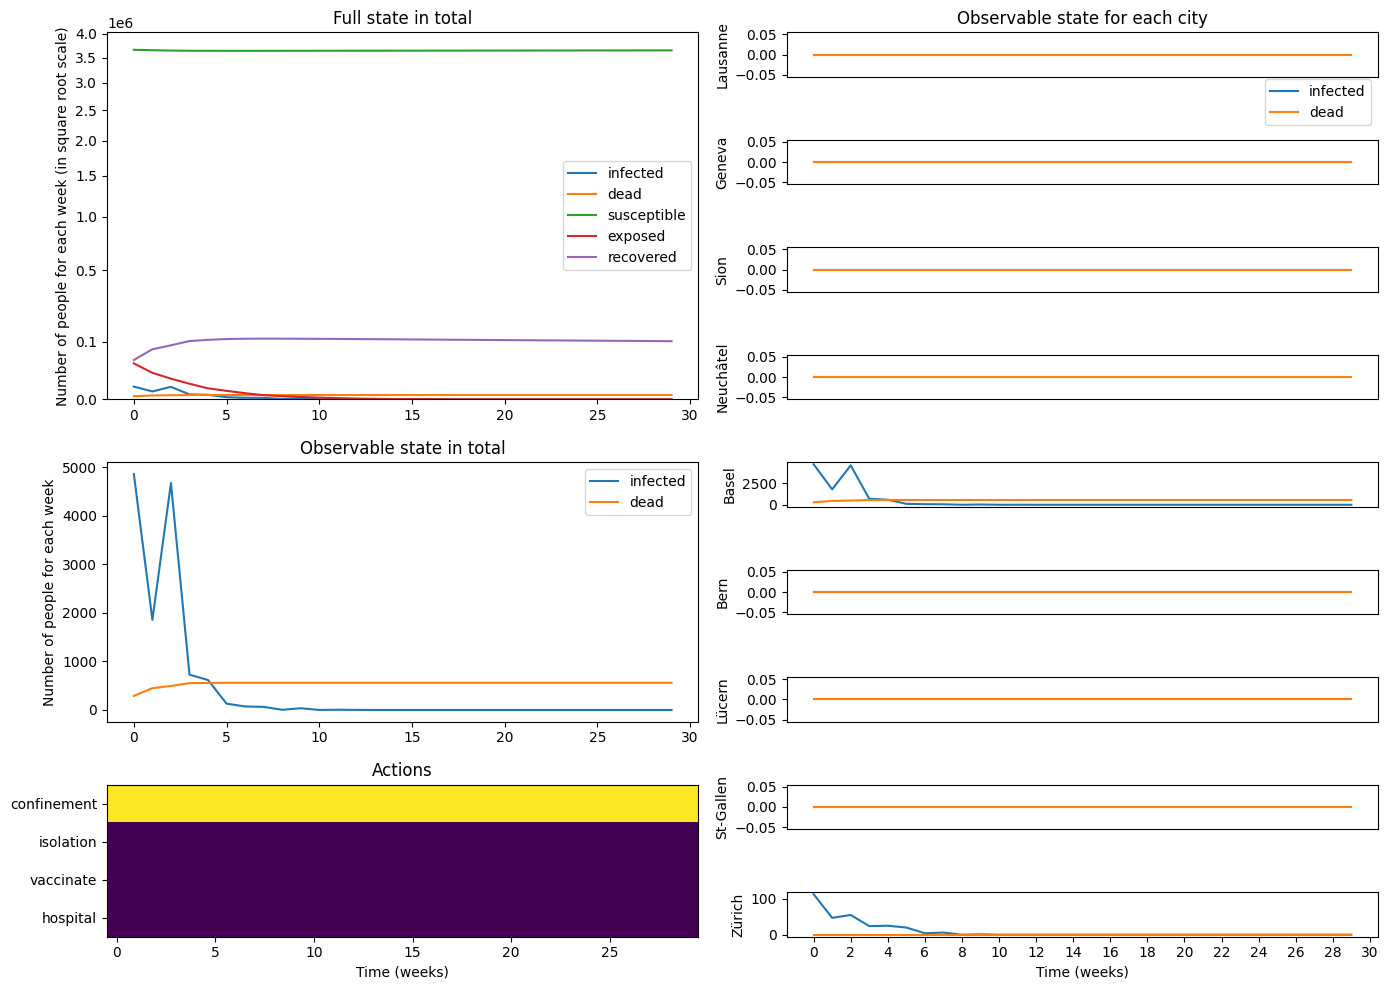

In [48]:
# Set the figure and the axes
fig = plt.figure(figsize=(14, 10))
ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1, 9)]
ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

# 2.a.1 A plot of variables s[w] total, e[w] total, i[w] total, r[w] total, d[w] total over time
[ax_leftstate.plot(y) for key, y in total.items() if key != "initial_population"]
ax_leftstate.legend([key for key in total.keys() if key != "initial_population"])
ax_leftstate.set_title('Full state in total')
ax_leftstate.set_ylabel('Number of people for each week (in square root scale)')
ax_leftstate.set_yscale('function', functions=(np.sqrt, np.square))
ax_leftstate.yaxis.set_major_formatter(ScalarFormatter())
ax_leftstate.set_yticks([0, 0.1e6, 0.5e6, 1e6, 1.5e6, 2e6, 2.5e6, 3e6, 3.5e6, 4e6])

# 2.a.2 A plot of variables i[w] total, d[w] total over time
[ax_leftobs.plot(total[y]) for y in ['infected','dead']]
ax_leftobs.legend(['infected','dead'])
ax_leftobs.set_title('Observable state in total')
ax_leftobs.set_ylabel('Number of people for each week')

# 2.a.4 A plot of the action taken by the policy over time
ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
ax_leftactions.set_title('Actions')
ax_leftactions.set_yticks([0,1,2,3])
ax_leftactions.set_yticklabels(list(actions.keys()))
ax_leftactions.set_xlabel('Time (weeks)')

# 2.a.3 A set of plots of variables i[w] city, d[w] city over time (one subplot per-city)
infected_line = ax_right["Zürich"].plot(cities["Zürich"]['infected'], label="infected")[0]
dead_line = ax_right["Zürich"].plot(cities["Zürich"]['dead'], label="dead")[0]

for c, ax in ax_right.items():
    if c != "Zürich":
        ax.plot(cities[c]['infected'])
        ax.plot(cities[c]['dead'])

[ax.set_ylabel(c) for c, ax in ax_right.items()]
[ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
ax_right['Lausanne'].set_title('Observable state for each city')
ax_right['Zürich'].set_xlabel('Time (weeks)')
ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

# Add a single overall legend for subplots in ax_right
legend = ax_right["Lausanne"].legend([infected_line, dead_line], ["infected", "dead"], loc="upper right", bbox_to_anchor=(1, 0.1))

fig.tight_layout()
plt.show()